In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import pandas as pd
%matplotlib inline

print(tf.__version__)

2.9.2


## Dataset

Download e preparação dos dados

In [2]:
# Esta célula faz o download do dataset completo
Sample_dataset = tfds.load("oxford_iiit_pet", split="train", try_gcs=True)
assert isinstance(Sample_dataset, tf.data.Dataset)
Sample_dataset 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDP93JQ/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteDP93JQ/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [4]:
path_csv = "/oxford_iiit_pet.csv"
path_images = "/root/tensorflow_datasets/downloads/extracted/images/images/"
formato = [".jpg", ".png"]

# Nesse dataset, os dados são separados por espaços, e as colunas não vem nomeadas
# por isso o seguinte tratamento
oxford_iiit_pet_dataset = pd.read_csv(path_csv, sep = " ", names ="Image CLASS_ID SPECIES BREED_ID".split())

# As imagens estão registradas apenas com o nome, então é adicionado o caminho local
# e em seguida é transformada em uma matriz compreensível para o matplotlib
oxford_iiit_pet_dataset["Image"] = [path_images + str(nome_img) + formato[0] for nome_img in oxford_iiit_pet_dataset["Image"]]


In [5]:
classes_names = ['gato', 'cachorro'] # 0: gato, 1: cachorro

In [6]:
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.utils import img_to_array, array_to_img

In [7]:
inputs_shape = (64,64) 
oxford_iiit_pet_dataset["Image"] = np.array([Image.open(img).convert('RGB').resize(inputs_shape, Image.ANTIALIAS) for img in oxford_iiit_pet_dataset["Image"]])
oxford_iiit_pet_dataset["Image"] = [img_to_array(img) for img in oxford_iiit_pet_dataset["Image"]]
#oxford_iiit_pet_dataset.tail() # as últimas linhas do dataframe

<ipython-input-7-b8415eb01e82>:2: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  oxford_iiit_pet_dataset["Image"] = np.array([Image.open(img).convert('RGB').resize(inputs_shape, Image.ANTIALIAS) for img in oxford_iiit_pet_dataset["Image"]])
<ipython-input-7-b8415eb01e82>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  oxford_iiit_pet_dataset["Image"] = np.array([Image

## Separação dos dados de treino e de teste

In [8]:
X = oxford_iiit_pet_dataset["Image"] # Conjunto de dados
y = oxford_iiit_pet_dataset["SPECIES"] # Conjunto "alvo / classe"

In [9]:
# divisão dos dados de teste (60%) e treino (40%)
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(X, y, test_size=0.4, random_state=101)


print(type(train_images), type(train_labels))

test_labels = test_labels.apply(lambda label: label - 1 )
train_labels = train_labels.apply(lambda label: label - 1 )

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [10]:
# Apenas para acessar os dados sem normalização
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

# Pré-processamento dos dados


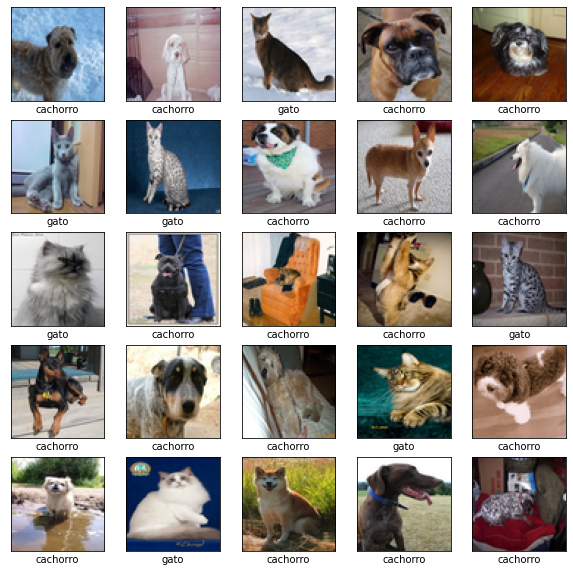

In [11]:
plt.figure(figsize=(10,10))

for i, x in enumerate(list(train_images.index[:25])):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(array_to_img(train_images[x]), cmap=plt.cm.binary)
    plt.xlabel(classes_names[train_labels[x]])
plt.show()

In [13]:
n = np.asarray([train_images[x] for x in train_images.index])
m = np.asarray([test_images[x] for x in test_images.index])

train_images = n
test_images = m

print(train_images.shape, "\t", test_images.shape)

(2208, 64, 64, 3) 	 (1472, 64, 64, 3)


IMG shape (64, 64, 3)


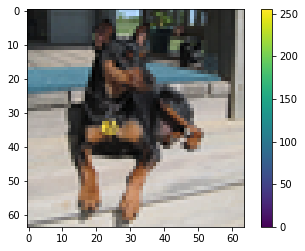

In [14]:
from tensorflow.keras.utils import array_to_img
print("IMG shape", train_images[0].shape)
plt.figure()
plt.imshow(array_to_img(train_images[15]))
plt.colorbar()
plt.grid(False)
plt.show()

# Contrução do Modelo

In [23]:
model = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(
        1. / 255.,
	      input_shape =  (64, 64, 3)
    ),
    tf.keras.models.Sequential([
	      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
	      tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
	      tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
    ]),
    tf.keras.layers.Conv2D(32, 3, padding="same", activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation = "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

In [24]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 sequential_2 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                  

In [25]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = 'binary_crossentropy',
    metrics = ["accuracy"]
)


#Treinamento do modelo
---



In [28]:
historico = model.fit(x = train_images, y = train_labels, validation_data = (test_images, test_labels), epochs=14, batch_size=32)

Epoch 1/14
69/69 [==============================] - 29s 422ms/step - loss: 0.5205 - accuracy: 0.7260 - val_loss: 0.5967 - val_accuracy: 0.6787
Epoch 2/14
69/69 [==============================] - 27s 396ms/step - loss: 0.5359 - accuracy: 0.7178 - val_loss: 0.6155 - val_accuracy: 0.6929
Epoch 3/14
69/69 [==============================] - 27s 398ms/step - loss: 0.5189 - accuracy: 0.7373 - val_loss: 0.5951 - val_accuracy: 0.7086
Epoch 4/14
69/69 [==============================] - 27s 398ms/step - loss: 0.5081 - accuracy: 0.7364 - val_loss: 0.5917 - val_accuracy: 0.7018
Epoch 5/14
69/69 [==============================] - 31s 445ms/step - loss: 0.5184 - accuracy: 0.7337 - val_loss: 0.6547 - val_accuracy: 0.7031
Epoch 6/14
69/69 [==============================] - 27s 398ms/step - loss: 0.5087 - accuracy: 0.7400 - val_loss: 0.5477 - val_accuracy: 0.7296
Epoch 7/14
69/69 [==============================] - 27s 396ms/step - loss: 0.4902 - accuracy: 0.7545 - val_loss: 0.5346 - val_accuracy: 0.7296

In [31]:
score = model.evaluate(test_images, test_labels, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 74.12%


#Análise do desempenho

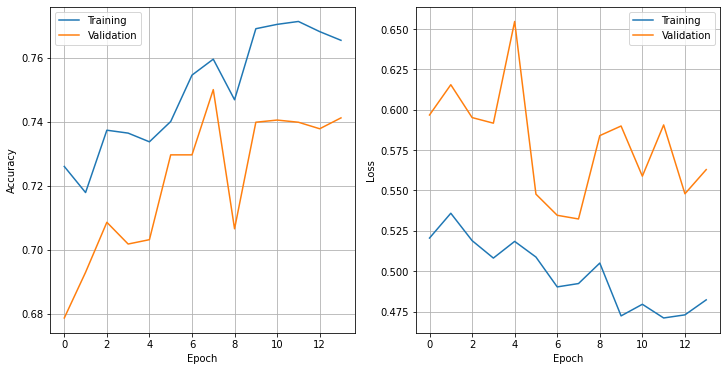

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.plot(historico.history['accuracy'])
ax1.plot(historico.history['val_accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Training', 'Validation'])
ax1.grid()

ax2.plot(historico.history['loss'])
ax2.plot(historico.history['val_loss'])
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Training', 'Validation'])
ax2.grid()

plt.show()

#Fazendo predições com o modelo treinado

In [51]:
predictions = model.predict(test_images)

46/46 [==============================] - 5s 105ms/step


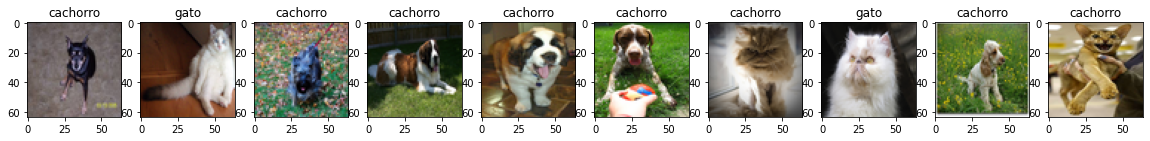

In [75]:
fig, ax = plt.subplots(1, 10, figsize=(20,6))
for i, x in enumerate(test_labels.index[:10]):
    predictedLabel = int(predictions[i][0] >= 0.5)
    ax[i].set_title(classes_names[predictedLabel])
    ax[i].imshow(X_test[x] / 255)

1/1 [==============================] - 0s 42ms/step
r:  0.3862193 0 0
Gato


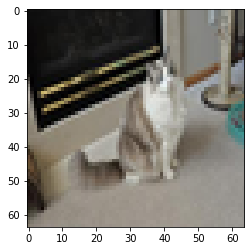

In [81]:
import numpy as np
from keras.preprocessing import image

img_path = path_images + "Ragdoll_145.jpg"

test_image = Image.open(img_path).convert('RGB').resize(inputs_shape, Image.ANTIALIAS)
plt.imshow(test_image)

test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print("r: ", result[0][0], np.argmax(result), int(result[0][0] >= 0.5))
if (int(result[0][0] >= 0.5) == 1):
    prediction = 'Cachorro'
else:
    prediction = 'Gato'

print(prediction)


#Salvando o modelo treinado

In [82]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model-weights.h5")

## Teste da leitura dos modelos salvos

In [84]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [85]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
loaded_model.load_weights("model-weights.h5")

score = loaded_model.evaluate(test_images, test_labels, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 74.12%
